In [105]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import category_encoders as ce
import datetime
import re

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# для нормализации, стандартизации
from sklearn import preprocessing

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [20]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [106]:
# Подгрузим наши данные из соревнования


df_train = pd.read_csv('/kaggle/input/sf-booking/hotels_train.csv')# датасет для обучения
df_test = pd.read_csv('/kaggle/input/sf-booking/hotels_test.csv') #датасет для предсказания
sample_submission = pd.read_csv('/kaggle/input/sf-booking/submission.csv')# самбмишн



# Иследование данных

In [108]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [23]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [24]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [25]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [26]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [27]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [109]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [87]:
data.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,country_France,country_Austria,day,count_nights
0,904,8.1,52,16670,62,1,45.533137,9.171102,0,0.0,1,0,0,0,0,0,2133,2
1,612,8.6,10,5018,0,7,52.385649,4.834443,0,0.0,0,1,0,0,0,0,2354,1
2,46,8.3,3,351,5,15,41.393192,2.161520,0,0.0,0,0,1,0,0,0,2736,1
3,241,9.1,0,1543,27,9,45.479888,9.196298,0,0.0,1,0,0,0,0,0,2776,1
4,834,9.1,0,4687,7,2,52.370545,4.888644,0,0.0,0,1,0,0,0,0,2564,2


In [69]:
print(f'Количество уникальных названий отелей: {data["hotel_name"].nunique()}\n')

# Даты первого и последнего отзывов
data['review_date'] = pd.to_datetime(data['review_date'])
print(f'Первая и последняя даты отзывов:\n{data["review_date"].agg(["min", "max"])}\n')

# Делаем срез и разделяем теги
tags_list = data['tags'].apply(lambda x: x[3:-3].split(" ', ' "))
tags = tags_list.explode(ignore_index=True)
print(f'Количество уникальных тегов: {tags.nunique()}\n')

print(f'Самый частый тег: {tags.mode()[0]}\n')

# С помощью регулярного выражения находим строки с тегом "остановок на ночь"
reg = 'S\w{5}\s\d+\sn\w{4,5}'
night_tags = tags.str.findall(reg).str.get(0)
print(f'Самый частый тег с указанием остановок на ночь: {night_tags.value_counts().index[0]}')

Количество уникальных названий отелей: 1492

Первая и последняя даты отзывов:
min   2015-08-04
max   2017-08-03
Name: review_date, dtype: datetime64[ns]

Количество уникальных тегов: 2428

Самый частый тег: Leisure trip

Самый частый тег с указанием остановок на ночь: Stayed 1 night


In [110]:
# Заполняем пропуски
data = data.fillna(0)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [73]:
#Преобразуем признак "hotel_adress" - адрес отеля


#Признак country
data['country'] = data['hotel_address'].apply(lambda x : 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

display(data['country'].value_counts())

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64

In [74]:
#Кодируем одинарно признак

encoder = ce.OneHotEncoder(cols=['country'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['country'])
data = pd.concat([data, type_bin], axis=1)

#удаляем не нужные столбцы
data = data.drop(['hotel_address'],axis=1)

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   hotel_name                                  515738 non-null  object        
 4   reviewer_nationality                        515738 non-null  object        
 5   negative_review                             515738 non-null  object        
 6   review_total_negative_word_counts           515738 non-null  int64         
 7   total_number_of_reviews                     515738 non-null  int64         
 8   positive_review                             515738 non-null  object       

In [111]:
#Создаем признак сколько дней назад оставили отзыв

data['review_date'] = pd.to_datetime(data['review_date'])
data_now = datetime.datetime.now()
data['day'] = (data_now - data['review_date']).dt.days

data.pop('review_date')

0        2017-07-21
1        2016-12-12
2        2015-11-26
3        2015-10-17
4        2016-05-16
            ...    
515733   2017-04-19
515734   2017-02-13
515735   2016-02-07
515736   2017-05-21
515737   2016-08-05
Name: review_date, Length: 515738, dtype: datetime64[ns]

In [112]:

#  Создаем новый признак count_nights (количество ночей)
def count_nights(tags):
    express = re.findall(r'Stayed\s([0-9]+)\snight', tags)
    row = ''.join(map(str,express))
    if len(row) == 0:
        return 1 # принимаем, что клиент оставаливался минимум на одну ночь
    else:
        return int(row)
data['count_nights'] = data['tags'].apply(count_nights)
data.head()

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,day,count_nights
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,2133,2
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,2354,1
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,2736,1
3,Piazza Della Repubblica 17 Central Station 201...,241,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0,2776,1
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0,2564,2


In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

In [113]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

<AxesSubplot:>

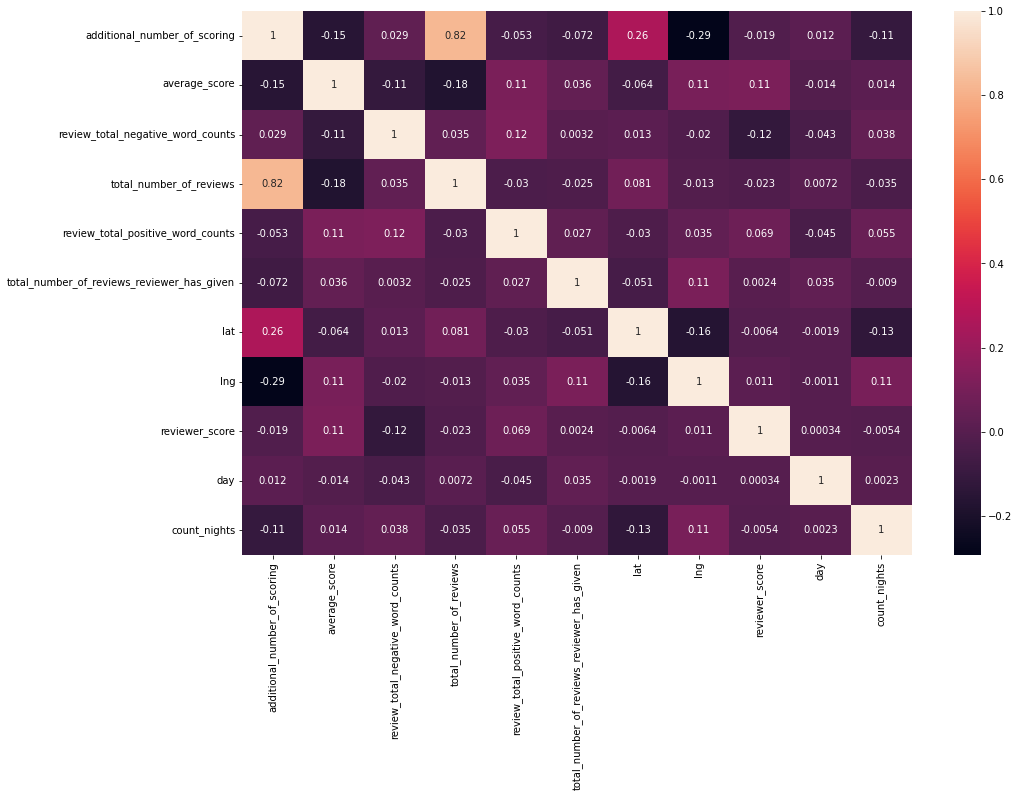

In [39]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

На графике видно, что мультипликативность в некоторых местах существует, но это важные признаки поэтому от них не будем избавляться.

In [86]:
data.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,country_France,country_Austria,day,count_nights
0,904,8.1,52,16670,62,1,45.533137,9.171102,0,0.0,1,0,0,0,0,0,2133,2
1,612,8.6,10,5018,0,7,52.385649,4.834443,0,0.0,0,1,0,0,0,0,2354,1
2,46,8.3,3,351,5,15,41.393192,2.161520,0,0.0,0,0,1,0,0,0,2736,1
3,241,9.1,0,1543,27,9,45.479888,9.196298,0,0.0,1,0,0,0,0,0,2776,1
4,834,9.1,0,4687,7,2,52.370545,4.888644,0,0.0,0,1,0,0,0,0,2564,2


In [84]:
#Нормализуем данные
data_clear = data.copy()
data_clear = data_clear.drop(['reviewer_score','lng','lat','count_nights','sample','country_Italy','country_Netherlands','country_Spain','country_United Kingdom','country_France','country_Austria'], axis = 1) 
col_names = list(data_clear.columns)

# инициализируем нормализатор RobustScaler
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
data_clear = mm_scaler.fit_transform(data_clear)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
data_clear = pd.DataFrame(data_clear, columns=col_names)

data_clear['reviewer_score'] = data['reviewer_score']
data_clear['lng'] = data['lng']
data_clear['lat'] = data['lat']
data_clear['count_nights'] = data['count_nights']
data_clear['sample'] = data['sample']
data_clear['country_Italy'] = data['country_Italy']
data_clear['country_Netherlands'] = data['country_Netherlands']
data_clear['country_Spain'] = data['country_Spain']
data_clear['country_United Kingdom'] = data['country_United Kingdom']
data_clear['country_France'] = data['country_Austria']

In [85]:
data_clear.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,day,reviewer_score,lng,lat,count_nights,sample,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,country_France
0,0.336815,0.630435,0.127451,1.000000,0.156962,0.000000,0.017808,0.0,9.171102,45.533137,2,0,1,0,0,0,0
1,0.227900,0.739130,0.024510,0.299212,0.000000,0.016949,0.320548,0.0,4.834443,52.385649,1,0,0,1,0,0,0
2,0.016785,0.673913,0.007353,0.018524,0.012658,0.039548,0.843836,0.0,2.161520,41.393192,1,0,0,0,1,0,0
3,0.089519,0.847826,0.000000,0.090215,0.068354,0.022599,0.898630,0.0,9.196298,45.479888,1,0,1,0,0,0,0
4,0.310705,0.847826,0.000000,0.279305,0.017722,0.002825,0.608219,0.0,4.888644,52.370545,2,0,0,1,0,0,0


In [114]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'reviewer_score'], axis=1)

In [92]:
print(train_data.info())
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 128935 to 515737
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  float64
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  float64
 3   total_number_of_reviews                     386803 non-null  float64
 4   review_total_positive_word_counts           386803 non-null  float64
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  float64
 6   day                                         386803 non-null  float64
 7   reviewer_score                              386803 non-null  float64
 8   lng                                         386803 non-null  float64
 9   lat                                         386803 non-null  floa

# Машинное обучение

In [115]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
X = train_data.drop(['reviewer_score'], axis = 1) 
y = train_data['reviewer_score']  
      

In [116]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
# Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [117]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)

In [118]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


<AxesSubplot:>

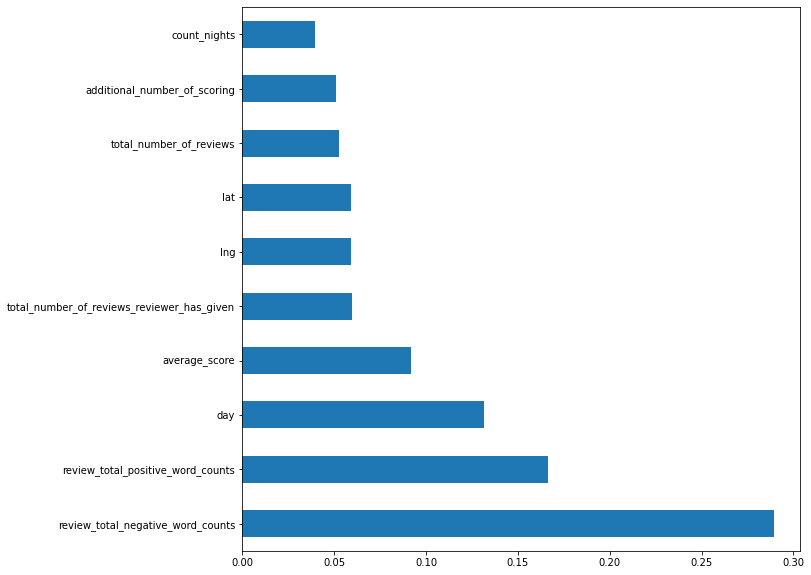

In [119]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Из графика мы видим,что страна регистрации отеля не так важна для модели, поэтому мы можем удалить этот признак.

In [120]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,day,count_nights
106416,428,8.6,0,2764,4,3,48.855566,2.292624,2593,1
4131,484,8.2,6,1827,0,1,51.480672,-0.007137,2468,1
88208,235,7.8,0,2251,9,9,41.385378,2.156723,2429,1
86676,91,8.9,44,631,0,1,41.396247,2.160955,2251,7
119525,1936,8.7,2,7491,10,3,51.510841,-0.078058,2542,2
38356,387,8.9,5,2695,59,5,41.384829,2.175128,2566,5
71442,53,7.9,4,939,2,1,48.251195,16.298917,2346,4
105351,531,9.0,3,2298,12,4,51.512196,-0.131838,2223,1
118479,44,8.1,0,824,13,5,45.494861,9.141551,2481,6
125588,275,8.6,31,1470,72,3,51.494806,-0.192653,2456,2


In [99]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [121]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


In [101]:
predict_submission

array([8.867, 7.465, 8.585, ..., 8.257, 9.711, 7.411])

In [123]:
list(sample_submission)

['reviewer_score', 'id']

In [124]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

,reviewer_score,id
0,8.872,488440
1,7.558,274649
2,8.470,374688
3,9.468,404352
4,9.858,451596
